**MACS205a - Differential equations**

*Group members:*
- *ABUBAKER Rita*
- *BERRONDO Alice*
- *LY Timothée*
- *PERSONNAZ Louis*
- *TOURTOIS Eliott*
- *WINTER Alexis*

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("hls")
from scipy.integrate import odeint, solve_ivp

# Detail equations 

$$\begin{bmatrix} 
    y_0 \\
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_6 \\
    y_7
\end{bmatrix} = \begin{bmatrix} 
    Atmosphere \\
    CarbonateRock \\
    DeepOcean\\
    FossilFuel \\
    Plant \\
    Soil \\
    SurfaceOcean \\
    VegLandAreaPercent
\end{bmatrix} $$

$$\begin{bmatrix} 
    y_0' \\
    y_1' \\
    y_2' \\
    y_3' \\
    y_4' \\
    y_5' \\
    y_6' \\
    y_7'
\end{bmatrix} (t) =
\begin{bmatrix}
    Kao*\frac{280}{y_0[0]}  & 0 & 0 & 0 & \frac{55}{y_4[0]} & \frac{55}{y_5[0]} & 0 & 0 \\
    0       & 0 & \frac{0,1} {y_2[0]} & 0 &0 &0 &0 & 0 \\
    0       & 0 & 0 & \frac {90,1} {y_3[0]} &0 &0 & \frac {90,1} {y_6[0]} & 0 \\
    0       & 0 & 0 & 0 &0 &0 &0 & 0 \\
    \frac {30800} {y_0[0]} &0 &0 &0 &\frac{55}{y_4[0]} & 0 & 0 &0 \\                                         
    0 &0 &0 &0 &\frac{55}{y_4[0]} & - \frac{55}{y_5[0]} & 0 &0 \\
    Kao \times \frac{280}{y_0[0]} &0 &\frac{90}{y_2[0]} &0 &0 &0 &- \frac{90.1}{y_6[0]} &0      \\
    0 &0 &0 &0 &0 &0 &0 &0  
\end{bmatrix} \times \begin{bmatrix} 
    y_0 \\
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_6 \\
    y_7
\end{bmatrix} (t) + \begin{bmatrix} 
    Deforestation + 0.1 + FFC - Photosynthesis - Kao*pC020c\\
    -Volcanoes \\
    0 \\
    -FossilFuelsCombustion \\
    0 \\
    \frac{Deforestation}{2} \\
    -Ka_0*pCO2Oc \\
    - 20 \frac{Deforestation}{y_4[0]}
\end{bmatrix}$$


On note que $y_0$ et $y_6$ sont non linéaires comme ils dépendent de $pCO2Oc = 280 * (0,035+0,0019*(10+0,01*(\frac {280 *y_0}{y_0[0]} -280)))  * \frac {HCO3^2}{CO3}$ qui dépend de $HCO3 = \frac {y_6}{12000 * SurfOcVol} - \sqrt{(\frac {y_6}{12000 * SurfOcVol})^2 - Alk*(2*\frac {y_6}{12000 * SurfOcVol} -Alk) * (1-4*KCarb)}*\frac 1 {1-4 KCarb}$ avec $KCarb=0,000575 + 0,000006*(10+ (\frac {y_0*280} {y_0[0]})*0,01)$ dépendant lui même de $y_0$ et $y_6$ et $CO3 = \frac {Alk-HCO3} 2$.

En voyant $y_0$ et $y_6$ comme des fonctions "boîtes noires" cachées mais connues, on peut réécrire le problème ainsi :

$$\begin{bmatrix} 
    y_1' \\
    y_2' \\
    y_3' \\
    y_4' \\
    y_5' \\
    y_7'
\end{bmatrix} (t) =
\begin{bmatrix}
    0       & 0 & \frac{0,1} {y_2[0]} & 0 &0 &0 &0 & 0 \\
    0       & 0 & 0 & \frac {90,1} {y_3[0]} &0 &0 & \frac {90,1} {y_6[0]} & 0 \\
    0       & 0 & 0 & 0 &0 &0 &0 & 0 \\
    \frac {30800} {y_0[0]} &0 &0 &0 &\frac{55}{y_4[0]} & 0 & 0 &0 \\                                         
    0 &0 &0 &0 &\frac{55}{y_4[0]} & - \frac{55}{y_5[0]} & 0 &0 \\
    0 &0 &0 &0 &0 &0 &0 &0  
\end{bmatrix} \times \begin{bmatrix} 
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_7
\end{bmatrix} (t) + \begin{bmatrix}
    -v \\
    \frac{90,1}{y_6[0]} y_6(t) \\
    -\varphi(t) \\
    \frac{30800}{y_0[0]} y_0(t) \\
    \frac{d}{2} \\
    - 20 \frac{d}{y_4[0]}
\end{bmatrix}$$

i.e.

$$y'(t) = A y(t) + b(t)$$

où $d = Deforestation$, $v = Volcanoes$ sont des constantes et $\varphi(t)$ est la combustibles de carburants fossiles au temps $t$.

# Code

In [2]:
# Initial conditions
Atmosphere_Initial          = 750
CarbonateRock_Initial       = 100000000
DeepOcean_Initial           = 38000
FossilFuel_Initial          = 7500
Plant_Initial               = 560
Soil_Initial                = 1500
SurfaceOcean_Initial        = 890
VegLandArea_percent_Initial = 100

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Fossil fuel
FossFuelData = np.array([[50.0, 0.00],
                         [75.0, 0.30],
                         [100.0, 0.60],
                         [125.0, 1.35],
                         [150.0, 2.85],
                         [175.0, 4.95],
                         [200.0, 7.20],
                         [225.0, 10.05],
                         [250.0, 14.85],
                         [275.0, 20.70],
                         [300.0, 30.00]])

In [3]:
# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)

def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return (FossFuelData[i-1,1]
             + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1]))

def derivative(x, t):
    Atmosphere          = x[0]
    CarbonateRock       = x[1]
    DeepOcean           = x[2]
    FossilFuelCarbon    = x[3]
    Plants              = x[4]
    Soils               = x[5]
    SurfaceOcean        = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial)) + (Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp
                    + SoilResp
                    + Volcanoes
                    + FossilFuelsCombustion_
                    - Photosynthesis
                    - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt = Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
    ])

    return derivative

In [4]:
class Model():
    """Represents a model for the carbon cycle"""
    
    def __init__(self, initial_conditions):
        self.initial_conditions = initial_conditions
        self.attr = {0: "Atmosphere",
                     1: "CarbonateRock",
                     2: "DeepOcean",
                     3: "FossilFuel",
                     4: "Plant",
                     5: "Soil",
                     6: "SurfaceOcean",
                     7: "VegLandArea_percent"}
        self.params  = list(self.attr.values())
        self.message = None
        self.success = None
        self.t       = None
        self.y       = None
        
    def predict(self, method_, startYear, endYear, *args, **kwargs):
        if method_ == "solve_ivp":
            t_span = (startYear, endYear)
            derivative_ = lambda t, y: derivative(y, t) # invert the order of the arguments for solve_ivp
            res = solve_ivp(fun=derivative_, t_span=t_span, y0=self.initial_conditions, *args, **kwargs)
            self.message, self.success, self.t, self.y = res.message, res.success, res.t, res.y
        if method_ == "RK4":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta4(f=derivative, y0=self.initial_conditions, t=self.t).T # transpose for plot
        if method_ == "RK2":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta2(f=derivative, y0=self.initial_conditions, t=self.t).T # transpose for plot
        if method_ == "RK1":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta1(f=derivative, y0=self.initial_conditions, t=self.t).T # transpose for plot
    def plot_evolution(self, params, figsize=None):
        if figsize is None: # adaptative figure size
            width = 20
            height = 5 * (1 + ((len(params)-1) // 3))
            figsize = (width, height)
        total = len(params)
        cols = 3
        rows = total // cols
        rows += total % cols
        position = range(1, total+1)
        fig = plt.figure(figsize=figsize)
        for k in range(total):
            ax = fig.add_subplot(rows, cols, position[k]) # create subplot at the right position
            idx = self.params.index(params[k]) # get index of attribute
            ax.plot(self.t, self.y[idx]) # plot evolution
            ax.set_xlabel("Time (years)")
            ax.set_ylabel(f"{params[k]}")
        plt.show()

In [5]:
def rungeKutta4(f, y0, t):
    """
    params:
    f: 2-params derivative function
    y0: initial condition
    t: array of years
    """
    n = len(t) 
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n-1):
        h = t[i+1] - t[i]
        
        p1 = f(y[i], t[i])
        t2 = t[i] + 1/2 * h
        y2 = y[i] + 1/2 * h * p1
        
        p2 = f(y2, t2)
        t3 = t2
        y3 = y[i] + 1/2 * h * p2
        
        p3 = f(y3, t3)
        t4 = t[i] + h 
        y4 = y[i] + h * p3
        
        p4 = f(y4, t4)
        
        y[i+1] = y[i] + h * (p1/6 + 2*p2/6 + 2*p3/6 + p4/6)
    
    return y

In [6]:
def rungeKutta2(f, y0, t):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i+1] - t[i]
        
        p1 = f(y[i], t[i])
        t2 = t[i] + 1/2 * h
        y2 = y[i] + 1/2 * h * p1
        
        p2 = f(y2, t2)
        
        y[i+1] = y[i] + h * (p1/2 + p2/2)
    return y

In [7]:
def rungeKutta1(f, y0, t):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i+1] - t[i]
        p1 = f(y[i], t[i])
        
        y[i+1] = y[i] + (t[i+1] - t[i]) * p1
    return y

In [8]:
initial_conditions = np.array([Atmosphere_Initial,
                               CarbonateRock_Initial,
                               DeepOcean_Initial,
                               FossilFuel_Initial,
                               Plant_Initial,
                               Soil_Initial,
                               SurfaceOcean_Initial,
                               VegLandArea_percent_Initial])
model = Model(initial_conditions)

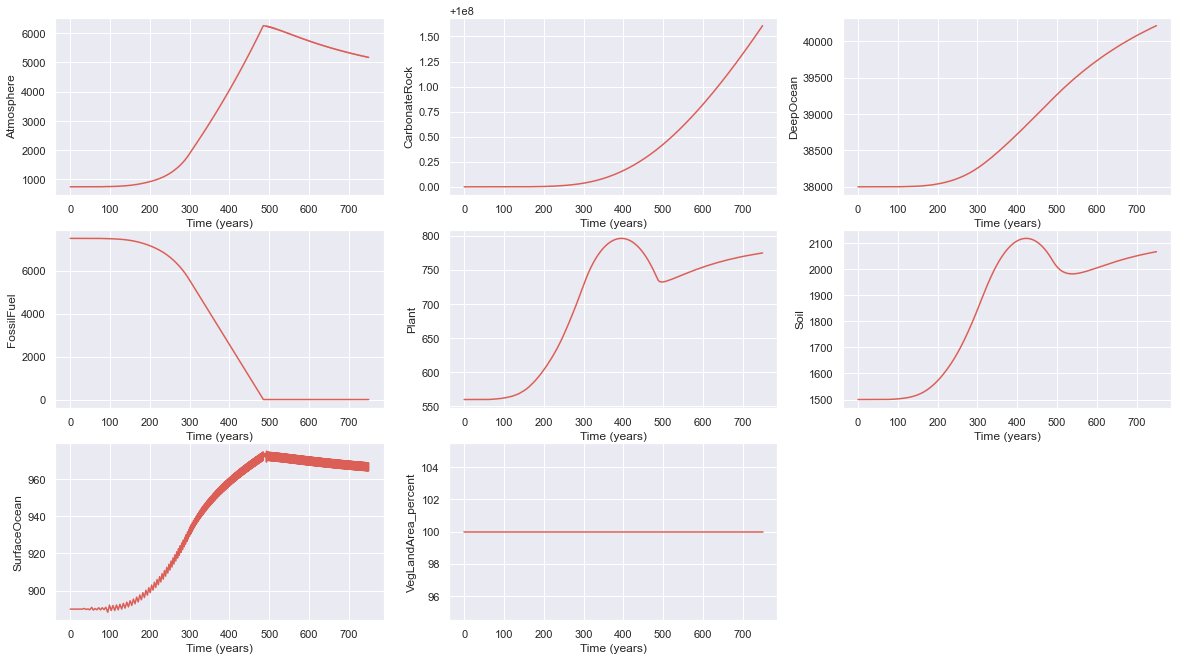

In [9]:
model.predict("solve_ivp", 0, 750, method="DOP853")
model.plot_evolution(model.params)

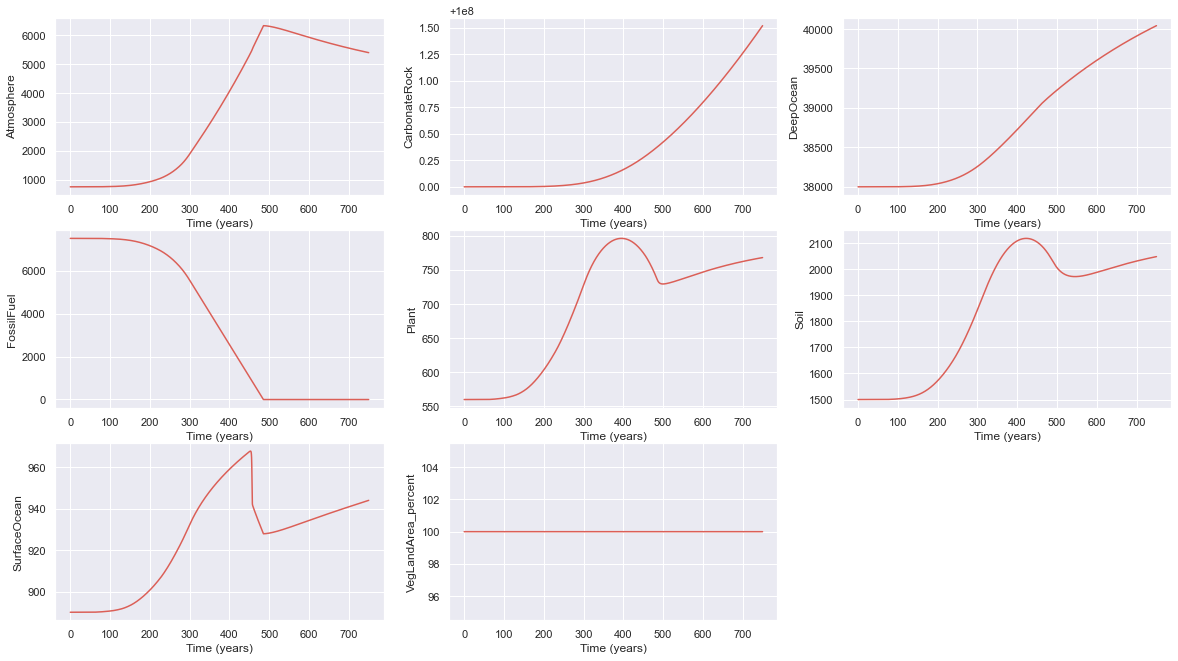

In [10]:
model.predict("RK4", 0, 750, num=3000)
model.plot_evolution(model.params)

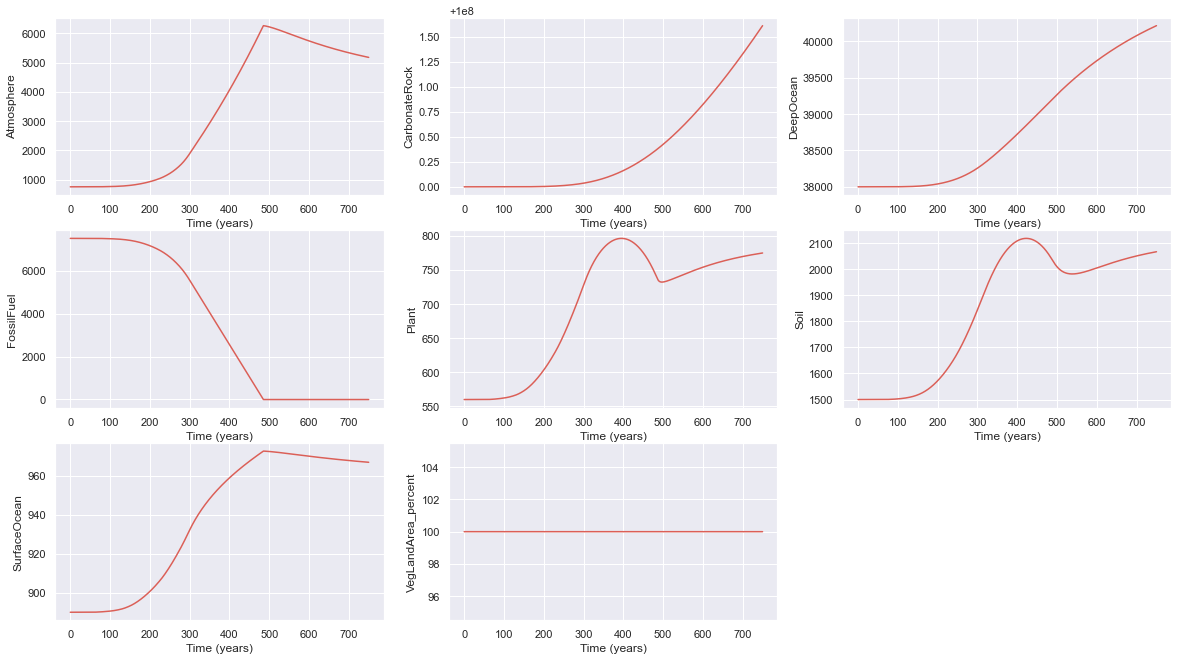

In [11]:
model.predict("RK2", 0, 750, num=3000)
model.plot_evolution(model.params)

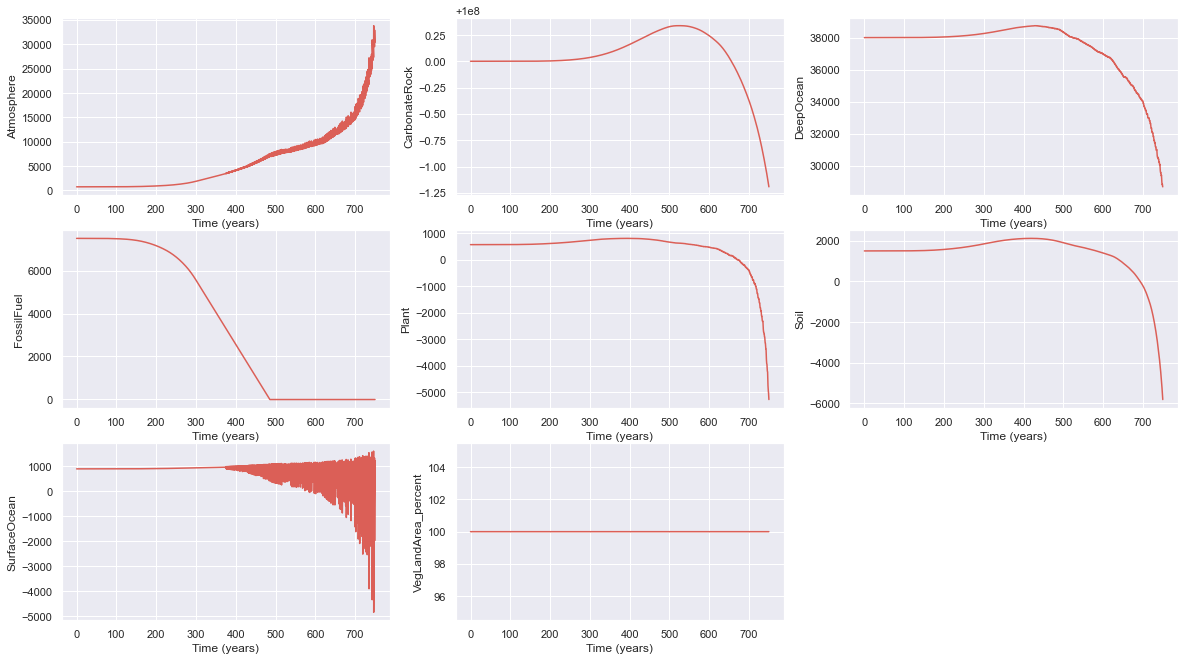

In [12]:
model.predict("RK1", 0, 750, num=2300)
model.plot_evolution(model.params)

In [13]:
model.predict("RK4", 0, 750, num=300000)
ref = model.y
def errors(x):
    errors=[]
    T= int(len(ref[0])/len(x[0]))
    for i in range(8):
        temp = ref[i][::T]
        error= np.linalg.norm(x[i]-temp)
        errors.append(error)
    return errors

In [14]:
model.predict("RK4", 0, 750, num=3000)
errors(model.y)

[6265.447522479518,
 1.4624329639802578,
 4364.81702937115,
 161.38200882455078,
 214.27448087841097,
 533.297315714692,
 1199.6785925977863,
 0.0]

In [23]:
import time

ERK4=[]
timeRK4 = []
ERK2=[]
timeRK2 = []
ERK1=[]
timeRK1 = []
indices = [3750,4000, 5000,6000,6250,7500,9375,10000,12000,12500,15000,18750,20000,25000,30000,37500,50000,60000,75000,100000,150000,300000]
for i in indices:
    
    ti = time.time()
    model.predict("RK4", 0, 750, num=i)
    tf = time.time()
    ERK4.append(errors(model.y))
    timeRK4.append(tf - ti)
    
    ti = time.time()
    model.predict("RK2", 0, 750, num=i)
    tf = time.time()
    ERK2.append(errors(model.y))
    timeRK2.append(tf - ti)
    
    ti = time.time()
    model.predict("RK1", 0, 750, num=i)
    tf = time.time()
    ERK1.append(errors(model.y))
    timeRK1.append(tf - ti)

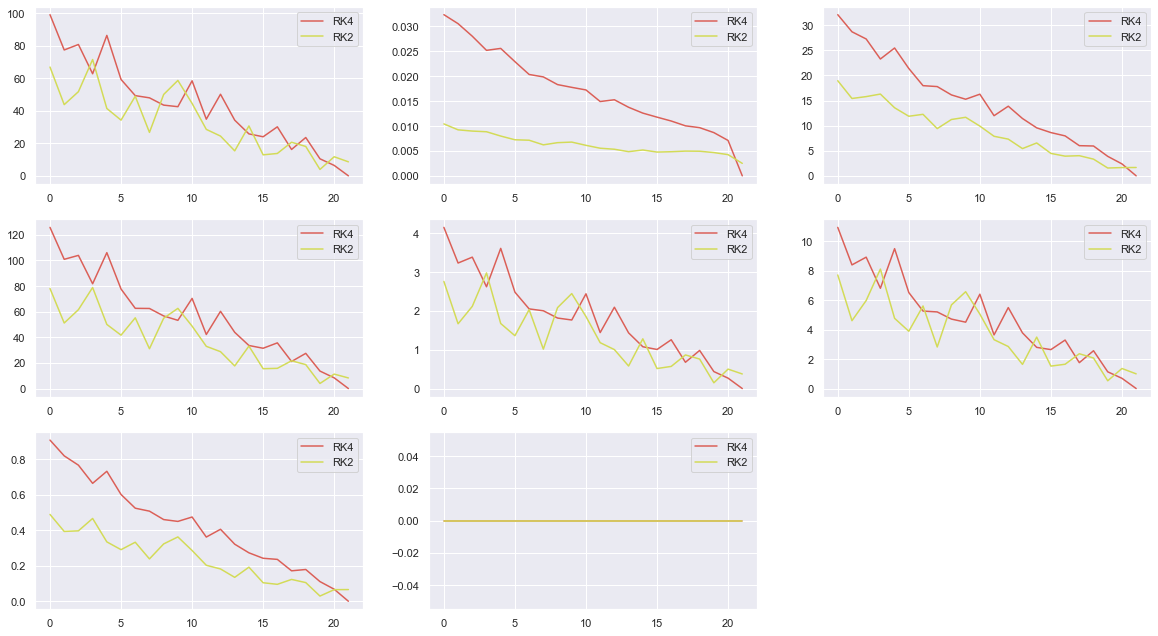

In [18]:
ERK4=np.array(ERK4)
ERK2=np.array(ERK2)
ERK1=np.array(ERK1)
total = 8
cols = 3
rows = total // cols
rows += total % cols
position = range(1, total+1)
width = 20
height = 5 * (1 + ((8-1) // 3))
figsize = (width, height)
fig = plt.figure(figsize=figsize)
for k in range(8):
    ax = fig.add_subplot(rows, cols, position[k])
    ax.plot(ERK4[:,k],label="RK4")
    ax.plot(ERK2[:,k],label="RK2")
    #ax.plot(ERK1[:,k],label="RK1")
    plt.legend()
plt.show()

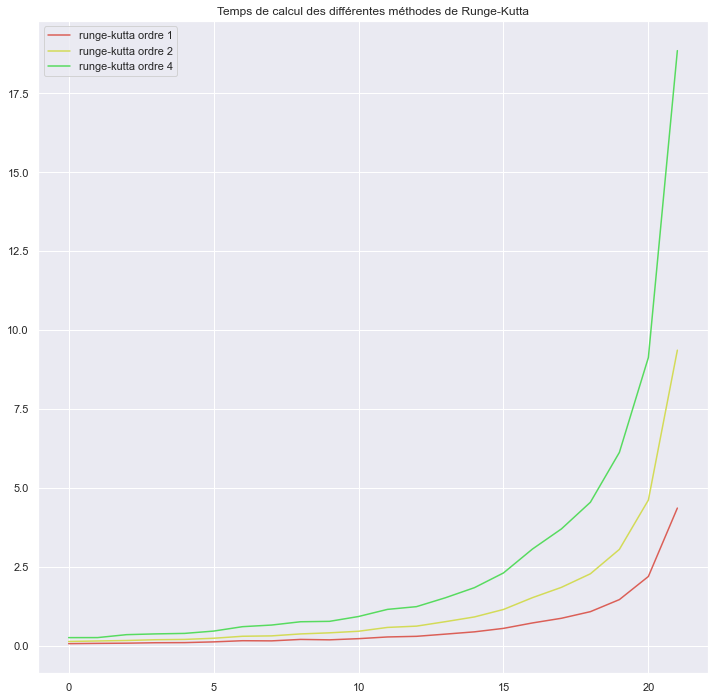

In [31]:
plt.figure(figsize=(12,12))

plt.plot(timeRK1, label='runge-kutta ordre 1')
plt.plot(timeRK2, label='runge-kutta ordre 2')
plt.plot(timeRK4, label='runge-kutta ordre 4')


plt.title("Temps de calcul des différentes méthodes de Runge-Kutta")
plt.legend()
plt.show()

In [ ]:
def cst_lambda(k, a, b, h_max, q):
    alpha = 0
    sum_a = 0
    
    
    for i in range(q):
        for j in range(i+1):
            sum_a += abs(a[i][j])
        if (alpha<sum_a):
            alpha = sum_a
        sum_a = 0
    
    sum_k = [(alpha*k*h_max)**j for j in range (q)]
    sum_b = [np.abs(b[j])*np.sum(sum_k[:j+1]) for j in range (q)]
    return k*np.sum(sum_b) 

cst_lambda(1, [[0]], [1], 0.01, 1)

In [ ]:
cst_lambda(1, [[0,0],[0.5,0]], [0.5,0.5], 0.01, 2)

In [ ]:
cst_lambda(1, [[0,0,0,0],[0.5,0,0,0],[0,0.5,0,0],[0,0,1,0]], [1/6,2/6,2/6,1/6],  0.01, 4)